In [4]:
%load_ext autoreload
%autoreload 2
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import os
from tqdm import tqdm
from load import load_data
tqdm.get_lock().locks = []
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# decleare data parameters
# out 00 -> without bln, 0.004
par_train = {'data_dir'         : '/data/LiftPose3D/capture', # change the path 
             'out_dir'          : '/data/LiftPose3D/capture/out_across_animals',
             'train_session_id' : [1,2,3],
             'test_session_id'  : [0],
             'test_cam_id'      : [0]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

In [6]:
train_3d, train_2d, train_keypoints ,test_3d, test_2d, test_keypoints, cams = load_data(par_train)

Loading data...
OK


In [54]:
from scipy.spatial.transform import Rotation as R
for c in cams['R']:
    r = R.from_matrix(c).as_euler('zyx', degrees=True)
    print(r)

#for c in cams['tvec']: 
#    print(c)
    
for c in cams['intr']: 
    print(c)

[-21.56981011   1.37332819  97.91485453]
[-12.25575809  -1.17331164 103.12804325]
[-12.25575809  -1.17331164 103.12804325]
[ 4.11215156  2.26506701 93.05644935]
[[3.13815209e+03 0.00000000e+00 5.83523022e+02]
 [0.00000000e+00 3.14222877e+03 8.19950713e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[3.28018963e+03 0.00000000e+00 7.16277868e+02]
 [0.00000000e+00 3.26436452e+03 5.47455596e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[3.28018963e+03 0.00000000e+00 7.16277868e+02]
 [0.00000000e+00 3.26436452e+03 5.47455596e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[4.07641979e+03 0.00000000e+00 7.12608040e+02]
 [0.00000000e+00 4.07125474e+03 5.21258792e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project, perturb_pose
from liftpose.vision_3d import intrinsic_matrix, calculate_bone_length
from liftpose.preprocess import obtain_projected_stats


angle_aug = {'eangles': {0: [[-180,180], [-2, 5], [90,110]]
                        #0: [[4,5], [2, 3], [92.5,93.5]], 
                        #1: [[61,62], [-2, -1], [105,106]],
                        #2: [[178,179], [1,2], [95, 96]],
                        #3: [[-26,-25], [-6,-5], [122,123]],
                        #4: [[-86,-85], [3,4], [99,100]],
                        #5: [[-162,-161], [3.5,4.5], [122,123]]
                        },
            'axsorder': 'zyx',
            'vis': None,
            'tvec': None,
            'intr': None}

bone_len = calculate_bone_length(test_3d, par_data['vis']['bones'])
avg_bone_len= np.nanmean(bone_len, axis=0)
std_bone_len= np.nanstd(bone_len, axis=0)

pose_aug = {'perturb': 1,
            'child': par_data["vis"]["child"],
            'bones': par_data['vis']['bones'],
            'avg_bone_len': avg_bone_len,
            'std_bone_len': std_bone_len}


stats = obtain_projected_stats({'train_3d':train_3d},
                               angle_aug['eangles'], 
                               angle_aug['axsorder'], 
                               angle_aug['vis'],
                               angle_aug['tvec'],
                               angle_aug['intr'],
                               par['roots'], 
                               par['target_sets'],
                               par['out_dir'],
                               load_existing=False,
                               th=1)

aug = [perturb_pose(**pose_aug), random_project(**angle_aug)]

lp3d_train(train_2d=None, test_2d={'test':test_2d},
           train_3d={'train':train_3d}, test_3d={'test':test_3d},
           train_keypts={'train':train_keypoints}, test_keypts={'test':test_keypoints}, 
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'], 
           training_kwargs={"epochs":20},
           augmentation=aug,
           stats=stats)

[preprocess.py:444]:INFO:Bootstrapping mean and variance...
[preprocess.py:531]:INFO:Expected error for obtaining projection stats: 437.4524737816155


/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:198: RuntimeWarning: invalid value encountered in true_divide
  tmp /= np.linalg.norm(tmp, ord='fro', axis=(1,2), keepdims=True)
/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:148: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(cp_d, axis=0)
/home/gosztolai/anaconda3/envs/LiftPose3D/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[preprocess.py:531]:INFO:Expected error for obtaining projection stats: 0.7153915271594471
[main.py:250]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/capture/out_across_animals/stat_2d.pth.tar.
[main.py:269]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/capture/out_across_animals/stat_3d.pth.tar.
[main.py:297]:INFO:Starting training model.
[main.py:307]:DEBUG:
==================Options=================
[main.py:308]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/capture/out_across_animals',
    'dropout': 0.5,
    'epochs': 20,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/capture/out_across_animals',
    'out_dir': '/data/LiftPose3D/capture/out_across_animals',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:309

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  1.40889|: 100%|██████████| 2471/2471 [00:23<00:00, 105.17it/s]
Epoch 001 | LR  0.00100 | Loss Test  1.26049 | Loss Train  1.05654|: 100%|██████████| 2471/2471 [00:23<00:00, 104.86it/s]
Epoch 002 | LR  0.00090 | Loss Test  1.34052 | Loss Train  0.98855|: 100%|██████████| 2471/2471 [00:23<00:00, 105.99it/s]
Epoch 003 | LR  0.00090 | Loss Test  1.38678 | Loss Train  0.95124|: 100%|██████████| 2471/2471 [00:23<00:00, 104.47it/s]
Epoch 004 | LR  0.00081 | Loss Test  1.38449 | Loss Train  0.93667|:  16%|█▌        | 393/2471 [00:04<00:19, 106.91it/s]

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


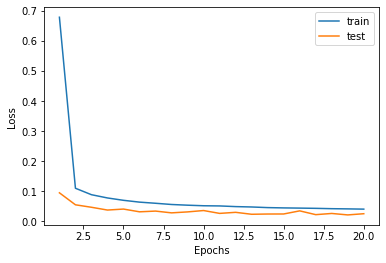

In [6]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [7]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:397]:INFO:starting testing in path: /data/LiftPose3D/capture/out_across_animals
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.31M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/capture/out_across_animals/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 20 | err: 2.5996864770694335)
[lift.py:103]:INFO:Saving results: /data/LiftPose3D/capture/out_across_animals/test_results.pth.tar


In [15]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world

data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)

#assert len(test_cam_id) == 1
cam = read_cam(session_id, test_cam_id[0])
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

s = test_3d_gt.shape
#test_3d_gt = camera_to_world(test_3d_gt.reshape(s[0], -1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred = camera_to_world(test_3d_pred.reshape(s[0],-1), cam['r'].T, cam['t']).reshape(s)
#test_3d_pred[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan
test_3d_gt[np.logical_not(test_keypoints.reshape(-1, 20, 3))] = np.nan

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[-214.16403     -5.1629004   81.79972  ]


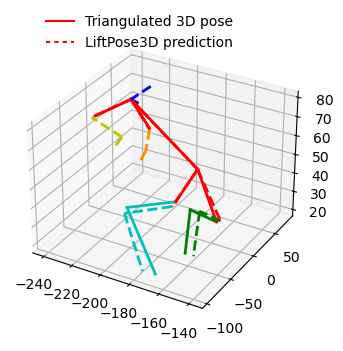

In [16]:
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d
%matplotlib widget
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
i=100
plot_pose_3d(ax=ax, tar=test_3d_gt[i],
             pred=test_3d_pred[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False, show_pred_always=True)      

origin = test_3d_gt[i][3]
print(origin)
#ax.set_xlim(origin[0]-100, origin[0]+100)
#ax.set_ylim(origin[1]-100, origin[1]+100)
#ax.set_zlim(-100,25)

KeyboardInterrupt: 

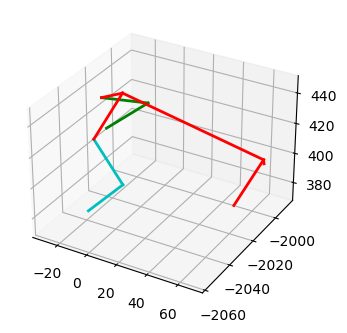

In [10]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
from celluloid import Camera
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

c = 0
for i in range(test_3d_gt.shape[0]):
    plot_pose_3d(ax=ax, tar=test_3d_gt[i],
                 pred=test_3d_pred[i],
                bones=par_data["vis"]["bones"], 
                limb_id=par_data["vis"]["limb_id"], 
                colors=par_data["vis"]["colors"], 
                normalize=False)
    origin = test_3d_gt[i][3]
    try:
        ax.set_xlim(origin[0]-100, origin[0]+100)
        ax.set_ylim(origin[1]-100, origin[1]+100)
        ax.set_zlim(-100,25)
        plt.savefig(f'out/pred{c}_missing.jpg')
        c += 1
    except:
        ax.clear()
        continue
    #camera.snap()
    ax.clear()

In [ ]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

t = 50
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"],
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False)

In [ ]:
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect('equal')
#ax.set_box_aspect([1,1,1])
#ax.view_init(elev=200, azim=60)
mat = read_data(0, 3)
pts3d = mat['data_3d'].reshape(-1,20,3)

plot_pose_3d(ax=ax, tar=pts3d[700],
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"], 
        normalize=True)        

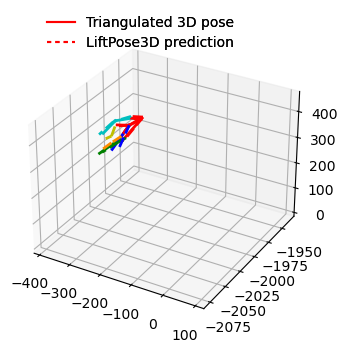

In [11]:
%matplotlib inline
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
from celluloid import Camera


#ax.view_init(elev=200, azim=60)

camera = Camera(fig)
for t in range(0, 100):
    plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False)
    camera.snap()
camera.animate().save('test.mp4')

In [ ]:
from IPython.display import Video
Video("test.mp4")

# Plot 2D

In [ ]:
mat

In [ ]:
frame_id = 1141
idx = np.where(mat[0]['data_sampleID'] == frame_id)[0][0]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(nrows=2, ncols=3, dpi=100, figsize=(20,10))
axs = np.ravel(np.array(axs))
for cam_id, ax in enumerate(axs):
    ax.imshow(plt.imread(f'images/sample0_{frame_id}_Camera{cam_list[cam_id]}.png'))
    pt = mat[cam_id]['data_2d'][idx].reshape(-1,2)
    ax.scatter(pt[:,0]-20, pt[:,1], c=marker_color[:20], s=5)
    ax.axis('off')

In [ ]:
%matplotlib widget
par_data = yaml.full_load(open('param.yaml', "rb"))
fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

ax.view_init(20,40)
i = 100
pts3d = mat[3]['data_3d'][i].reshape(-1,3)

for k in np.where(np.isnan(pts3d))[0]:
    pts3d[k] = pts3d[k-1]

plot_pose_3d(ax=ax, tar=pts3d,
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"],
            normalize=False)

# Check original dataset data

In [ ]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
from celluloid import Camera
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.set_aspect('equal')
#ax.set_box_aspect([1,1,1])
#ax.view_init(elev=200, azim=60)
mat = read_data(0, 3)
camera = Camera(fig)

pts3d = mat['data_3d'].reshape(-1,20,3)[400:500]

for i in range(pts3d.shape[0]):
    plot_pose_3d(ax=ax, tar=pts3d[i],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"], 
            normalize=False, show_pred_always=True)        
    camera.snap()
    #ax.clear()

camera.animate().save('test2.mp4')

In [ ]:
from IPython.display import Video
Video("test2.mp4")

In [ ]:
plt.title('Percentage of missing 3D points per joint')
plt.scatter(np.arange(20), np.sum(np.isnan(mat[5]['data_3d'].reshape(-1,20,3)),axis=(0,2))/3/mat[5]['data_3d'].shape[0] * 100)
plt.gca().set_xticks(range(20))
plt.gca().set_xticklabels([_[0] for _ in meta['markernames']], rotation='vertical', fontsize=18)
plt.ylabel('Percentage')

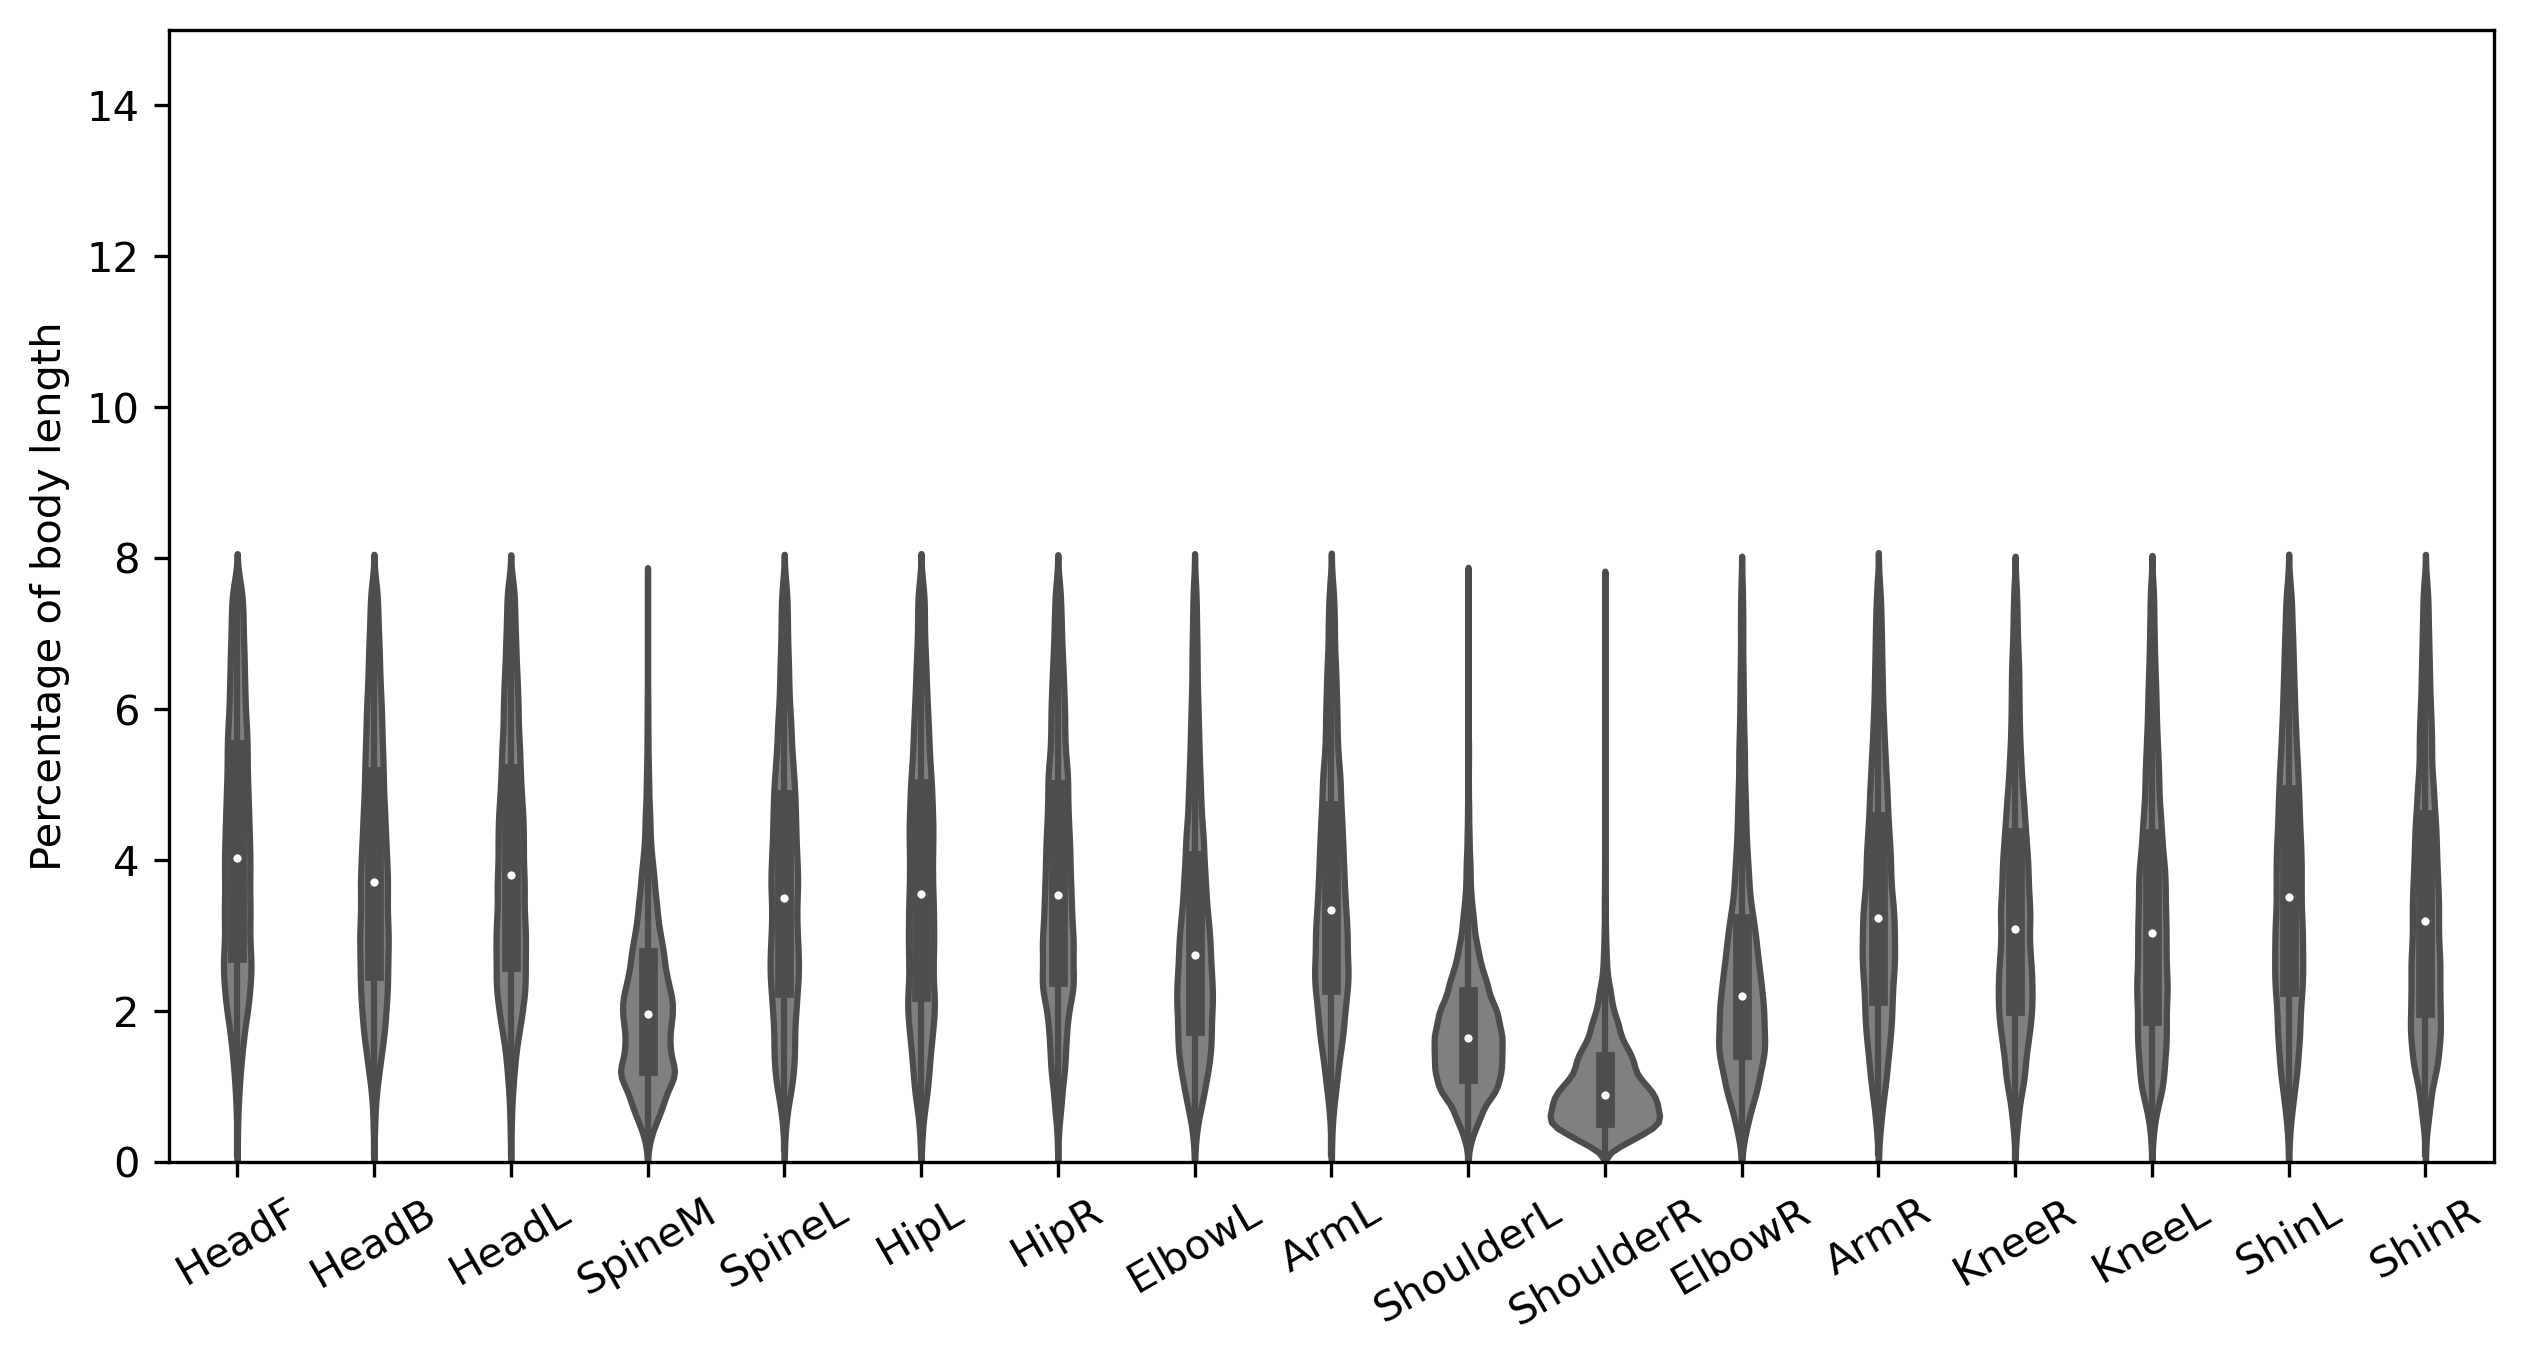

In [14]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

joints_name = par_data['vis']['names']
err_norm = np.sum(np.abs((test_3d_gt - test_3d_pred).reshape(test_3d_gt.shape[0], 20, 3)), axis=-1)
err_norm_sp = err_norm.copy()
joints_list = list()
    
for j in range(20):
    q = np.quantile(err_norm[:,j], 0.90)
    err_norm_sp[err_norm_sp[:,j] > q, j] = q

e_list = list()
n_list = list()
for i in range(err_norm_sp.shape[0]):
    for j in range(err_norm_sp.shape[1]):
        if not np.isnan(err_norm_sp[i,j]):
            if test_keypoints[i,j,0]:
                e_list.append(err_norm_sp[i,j] / 263.67092825261545 * 100)
                n_list.append(joints_name[j][0])

d = pd.DataFrame({"err":e_list, "joint": n_list})

q = d.quantile(q=0.95)
d = d.loc[d['err'] < q['err']]

plt.figure(dpi=300, figsize=(10,5))
plt.grid(False)
s = sns.violinplot(x="joint" , y="err", data=d, color='gray', order=order)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.xlabel('')
plt.ylabel('Percentage of body length')
plt.ylim([0,15])
plt.savefig('errors.png')

In [13]:
order = ['HeadF',
         'HeadB',
         'HeadL',
         'SpineM',
         'SpineL',
         'HipL',
         'HipR',
         'ElbowL',
         'ArmL',
         'ShoulderL',
         'ShoulderR',
         'ElbowR',
         'ArmR',
         'KneeR',
         'KneeL',
         'ShinL',
         'ShinR']